In [ ]:
import pandas as pd
import torch
import torchvision.datasets
import time

from google.colab import data_table
data_table.enable_dataframe_formatter()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import numpy as np

In [ ]:
plt.figure(figsize=(5,3))

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>


Chosed dataset [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html
)



In [ ]:
images_train = torchvision.datasets.CIFAR10(root= './',download = True, train = True)
images_test = torchvision.datasets.CIFAR10(root = './',download = True,  train = False)

100%|██████████| 170498071/170498071 [00:03<00:00, 46899966.16it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


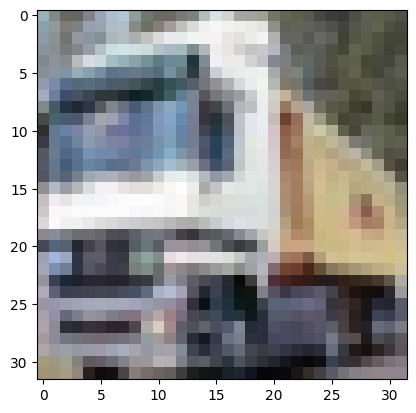

In [ ]:
plt.imshow(images_train[1][0])

In [ ]:
print(images_train[1][1])

9


In [ ]:
images_train.classes[9]

'truck'

In [ ]:
images_train[1][1].dtype

AttributeError: 'int' object has no attribute 'dtype'

Transfrom data in to torch tensors and Normalizating data

In [ ]:
X_train = torch.FloatTensor(images_train.data)
y_train = torch.LongTensor(images_train.targets)
X_test = torch.FloatTensor(images_test.data)
y_test = torch.LongTensor(images_test.targets)

In [ ]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

50000 50000
10000 10000


In [ ]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [ ]:
X_train /=255
X_test /=255

In [ ]:
X_train.min(), X_train.max()

(tensor(0.), tensor(1.))

In [ ]:
X_train.shape

torch.Size([50000, 32, 32, 3])

Some view on datasets

frog  =  tensor(6)   |  
truck  =  tensor(9)   |  
truck  =  tensor(9)   |  
deer  =  tensor(4)   |  
automobile  =  tensor(1)   |  
automobile  =  tensor(1)   |  
bird  =  tensor(2)   |  
horse  =  tensor(7)   |  
ship  =  tensor(8)   |  
cat  =  tensor(3)   |  


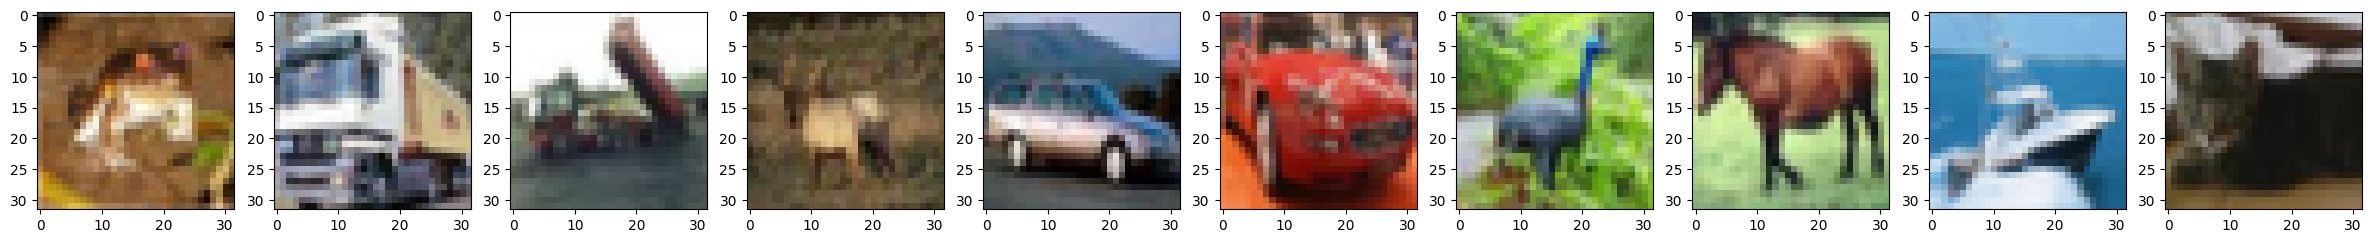

In [ ]:
plt.figure(figsize=(30,20))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    print(images_train.classes[y_train[i]],' = ',y_train[i],'  |  ')

Reshaping to [images,channels,height,width] because torch understand [images,channels,height,weight]

In [ ]:
X_train = X_train.permute(0,3,1,2)
X_test = X_test.permute(0,3,1,2)

In [ ]:
X_train.shape

torch.Size([50000, 3, 32, 32])

First model with parameters
поменять активации,пулинги на параметры

In [ ]:
#leNet example
class ConvNet(torch.nn.Module):
  def __init__(self,
               activation='relu',
               pooling='max',
               conv_size=5,
               use_batch_norm=False,
               dropout_neuron_probab = 0.0):
    # initializing parameters
    super(ConvNet,self).__init__()
    self.conv_size = conv_size
    self.use_batch_norm = use_batch_norm
    self.dropout = torch.nn.Dropout(dropout_neuron_probab)
    self.dropout2d = torch.nn.Dropout2d(dropout_neuron_probab)


    if activation == 'relu':
      self.act = torch.nn.ReLU()
    elif activation == 'elu':
      self.act = torch.nn.ELU()
    elif activation == 'selu':
      self.act = torch.nn.SELU()


    if pooling =='avg':
      self.pool = torch.nn.AvgPool2d(kernel_size=2,stride=2)
    elif pooling =='max':
      self.pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)

    if conv_size==5:
      self.conv1 = torch.nn.Conv2d(3,6,kernel_size=5,padding=0)
    elif conv_size==3:
      self.conv1_1 = torch.nn.Conv2d(3,6,kernel_size=3,padding=0)
      self.conv1_2 = torch.nn.Conv2d(6,6,kernel_size=3,padding=0)

    if use_batch_norm==True:
      self.bn1 = torch.nn.BatchNorm2d(num_features=6)


    if conv_size==5:
      self.conv2 = torch.nn.Conv2d(6,16,kernel_size=5,padding=0)
    elif conv_size==3:
      self.conv2_1 = torch.nn.Conv2d(6,16,kernel_size=3,padding=0)
      self.conv2_2 = torch.nn.Conv2d(16,16,kernel_size=3,padding=0)

    if use_batch_norm==True:
      self.bn2 = torch.nn.BatchNorm2d(num_features=16)

    self.fc1 = torch.nn.Linear(16*5*5,120)
    self.fc2 = torch.nn.Linear(120,84)
    self.fc3 = torch.nn.Linear(84,10)

  # learning
  def forward(self,x):

    #2x conv-batch_norm-dropout-act-pool layers
    if self.conv_size == 5:
      x = self.conv1(x)
    elif self.conv_size == 3:
      x = self.conv1_2(self.conv1_1(x))

    if self.use_batch_norm ==True:
      x = self.bn1(x)
    x = self.dropout2d(x)

    x = self.act(x)
    x = self.pool(x)


    if self.conv_size == 5:
      x = self.conv2(x)
    elif self.conv_size == 3:
      x = self.conv2_2(self.conv2_1(x))

    if self.use_batch_norm ==True:
      x = self.bn2(x)
    x = self.dropout2d(x)

    x = self.act(x)
    x = self.pool(x)

    #fully-connected layers, reshaping torch.tensor
    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

    x = self.dropout(x)
    x = self.act(self.fc1(x))
    x = self.dropout(x)
    x = self.act(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x

  #learning without dropouts with ended global batch-normalization
  def predict(self,x):

    if self.conv_size == 5:
      x = self.conv1(x)
    elif self.conv_size == 3:
      x = self.conv1_2(self.conv1_1(x))

    if self.use_batch_norm ==True:
      x = self.bn1(x)

    x = self.act(x)
    x = self.pool(x)


    if self.conv_size == 5:
      x = self.conv2(x)
    elif self.conv_size == 3:
      x = self.conv2_2(self.conv2_1(x))

    if self.use_batch_norm ==True:
      x = self.bn2(x)

    x = self.act(x)
    x = self.pool(x)

    x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.fc3(x)

    return x


Как проверять размеры тензора после сверток и пулингов и активаций

In [ ]:
#x= torch.ones((1,3,32,32))

In [ ]:
# c1 = torch.nn.Conv2d(3,6,kernel_size=5,padding=0)
# c2 = torch.nn.Conv2d(6,16,kernel_size=5,padding=0)
# a = torch.nn.ReLU()
# p = torch.nn.MaxPool2d(kernel_size=2,stride=2)

In [ ]:
# p(a(c2(p(a(c1(x)))))).shape

Обучение

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
class EarlyStopper:
  def __init__(self,patience = 1,min_delta = 0.015):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_train_loss = np.inf
    self.min_validation_loss = np.inf

  def early_stop(self,validation_loss,train_loss=0,use_train_loss=False):
    if use_train_loss:
      if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta) and (train_loss-self.min_train) <=0:
        self.counter+=1
        if self.counter >= self.patience:
          return True

      if train_loss <self.min_train_loss:
        self.min_train_loss = train_loss
      return False

    else:
      if validation_loss < self.min_validation_loss:
        self.min_validation_loss = validation_loss
        self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
        self.counter+=1
        if self.counter >= self.patience:
          return True
      return False

In [ ]:
## add user parameters on loss,optimizer
def train(model,X_train,y_train,X_test,y_test,regularization,batch_sz,early_stopper = EarlyStopper(),use_early_stopper=False,verbose = False):

  #earlystopper that will stop training
  earlystop = early_stopper

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  #default parameters (need to be changed by user)
  loss = torch.nn.CrossEntropyLoss()

  #l2 regularization which called 'ridge' (Лассо)
  optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3,weight_decay = regularization)

  batch_size = batch_sz

  test_accuracy_history = []
  test_loss_history = []
  train_loss_history = []

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  #need to be define number of epochs
  for epoch in range(25):
    order = np.random.permutation(len(X_train))
    train_loss_epoch = []
    for start_index in range(0, len(X_train), batch_size):
      #defining the ema(exponentional moving average) on collecting data to global normalization in BatchNorm when it is True
      model.train()
      optimizer.zero_grad()

      batch_indexes = order[start_index:start_index+batch_size]

      X_batch = X_train[batch_indexes].to(device)
      y_batch = y_train[batch_indexes].to(device)

      preds = model.forward(X_batch)

      loss_value = loss(preds, y_batch)
      train_loss_epoch.append(loss_value.detach().numpy())
      loss_value.backward()
      optimizer.step()

    #after collecting data of all batches in epoch BatchNorm ready  to made a global normalization
    model.eval()


    train_loss = np.mean(train_loss_epoch)
    train_loss_history.append(train_loss)

    #need to use with torch.no_grad()
    with torch.no_grad():
      test_preds = model.forward(X_test)
      loss_val = loss(test_preds, y_test).data.cpu().item()
      test_loss_history.append(loss_val)

      accuracy = (test_preds.argmax(dim=1)==y_test).float().mean().data.cpu().item()
      test_accuracy_history.append(accuracy)

      if verbose:
        print("Epoch is ",epoch, ', loss_train:',train_loss, ', loss_val:', loss_val, ', accuracy:', accuracy )

      if use_early_stopper:
        #user should define do we need to use train_loss
        if early_stopper.early_stop(validation_loss = loss_val,train_loss = train_loss,use_train_loss = False):
          print('Early stopper stopped training on epoch: ',epoch)
          break

  del model
  return train_loss_history,test_loss_history,test_accuracy_history

**GLOBAL PARAMETERS ON MODEL EXCEPT ARCHITECTURE**


Adding dropout2d for convolutional, learning rate on optimizer
less batches - better than large batches (Не всегда большие батчи - это хорошо. Маленький батч дает больше рандомности в градиентный спуск. Что позволяет, например, избегать локальных минимумов: для каждого батча ближайший минимум, к которому он сходится, свой. Чем меньше батч - тем сильнее его ближайший минимум отличается от таковых у соседних батчей. )

In [ ]:
# activations = ['relu']
# use_batch_norms = [True]
# poolings = ['max']
# conv_sizes = [3,5]
# regularizations = [1.0e-5]
# dropouts = [0.05]
# batches = [200]

activations = ['relu','tanh']
use_batch_norms = [True]
poolings = ['avg','max']
conv_sizes = [3,5]
#lambda of ridge l2 regularization(Лассо)
regularizations = [1.0e-5]
#works on fully-connected layers to except overfitting
dropouts = [0.1,0.15]
batches = [100]

#to do
epochs = []
losses = []
optimezers = []

**old view of collecting all data from models**

In [ ]:
# accuracies = {}
# losses_test = {}
# losses_train = {}
# for activation in activations:
#   for pooling in poolings:
#     for batch_norm in use_batch_norms:
#       for conv_size in conv_sizes:
#         for regularization in regularizations:
#           for dropout in dropouts:
#             for batch in batches:
#               losses_train["Activ: ",activation,
#                    " Pooling: ",pooling,
#                    " BatchNorm: ",str(batch_norm),
#                    ' ConvSize: ',str(conv_size),
#                    ' Regularization: ',str(regularization),
#                    ' Dropout: ',str(dropout),
#                    ' Batch: ',str(batch)] ,\
#               losses_test["Activ: ",activation,
#                  " Pooling: ",pooling,
#                  " BatchNorm: ",str(batch_norm),
#                  ' ConvSize: ',str(conv_size),
#                  ' Regularization: ',str(regularization),
#                  ' Dropout: ',str(dropout),
#                  ' Batch: ',str(batch)] ,\
#               accuracies["Activ: ",activation,
#                    " Pooling: ",pooling,
#                    " BatchNorm: ",str(batch_norm),
#                    ' ConvSize: ',str(conv_size),
#                    ' Regularization: ',str(regularization),
#                    ' Dropout: ',str(dropout),
#                    ' Batch: ',str(batch)] = \
#               train(ConvNet(activation=activation,
#                       pooling=pooling,
#                       use_batch_norm=batch_norm,
#                       conv_size = conv_size,
#                       dropout_neuron_probab= dropout),
#               X_train,y_train,X_test,y_test,regularization,batch)

In [ ]:
df = pd.DataFrame(columns = ['name','loss_train','loss_test','accuracy_test'])
i=1
start_time = time.time()
total_models = len(activations)*len(poolings)*len(use_batch_norms)*len(conv_sizes)*len(regularizations)*len(dropouts)*len(batches)
for activation in activations:
  for pooling in poolings:
    for batch_norm in use_batch_norms:
      for conv_size in conv_sizes:
        for regularization in regularizations:
          for dropout in dropouts:
            for batch in batches:
              print("Current model: "+str(i)+"/"+str(total_models)+" Activ: "+str(activation)+
                      " Pooling: "+str(pooling)+
                      " BatchNorm: "+str(batch_norm)+
                      " ConvSize: "+str(conv_size)+
                      " Regularization: "+str(regularization)+
                      " Dropout: "+str(dropout)+
                      " Batch: "+str(batch)+
                      " Elapsed time : "+ str(time.time()-start_time))
              loss_train,loss_test,accuracy_test = train(ConvNet(
                  activation=activation,
                  pooling=pooling,
                  use_batch_norm=batch_norm,
                  conv_size = conv_size,
                  dropout_neuron_probab= dropout),
                  X_train,y_train,X_test,y_test,regularization,batch,EarlyStopper(2,0.01),use_early_stopper = True,verbose=True)
              i+=1
              df = pd.concat([
                  df,
                  pd.DataFrame({'name' : str(
                      "Activ: "+str(activation)+
                      " Pooling: "+str(pooling)+
                      " BatchNorm: "+str(batch_norm)+
                      " ConvSize: "+str(conv_size)+
                      " Regularization: "+str(regularization)+
                      " Dropout: "+str(dropout)+
                      " Batch: "+str(batch)
                      ),
                   'loss_train' : [loss_train],
                   'loss_test' : [loss_test],
                   'accuracy_test' : [accuracy_test]
                  })
              ],ignore_index = True)

print("All models [",i,"/",total_models,"] trained, elapsed time : ",time.time()-start_time)

Current model: 0 Activ: relu Pooling: avg BatchNorm: True ConvSize: 3 Regularization: 1e-05 Dropout: 0.1 Batch: 100 Elapsed time : 0.0003101825714111328
Epoch is  0 , loss_train: 1.7430955 , loss_val: 1.4636492729187012 , accuracy: 0.4645000100135803
Epoch is  1 , loss_train: 1.5445517 , loss_val: 1.4087227582931519 , accuracy: 0.4875999987125397
Epoch is  2 , loss_train: 1.469971 , loss_val: 1.321708083152771 , accuracy: 0.5285000205039978
Epoch is  3 , loss_train: 1.4172226 , loss_val: 1.2480993270874023 , accuracy: 0.5601999759674072
Epoch is  4 , loss_train: 1.3743694 , loss_val: 1.2395087480545044 , accuracy: 0.5619999766349792
Epoch is  5 , loss_train: 1.3387996 , loss_val: 1.2257602214813232 , accuracy: 0.5687999725341797
Epoch is  6 , loss_train: 1.3113108 , loss_val: 1.1655681133270264 , accuracy: 0.5875999927520752
Epoch is  7 , loss_train: 1.275955 , loss_val: 1.133570909500122 , accuracy: 0.6054999828338623
Epoch is  8 , loss_train: 1.251189 , loss_val: 1.1534234285354614 ,

Need to choose better model parameters by accuracy on test validation. **IT DOESNT WORK AS DEFINITION OF QUALITY OF MODEL BECAUSE WE NEED TEST DATASET JUST FOR PREDICTS NOTHING ELSE**(*we took test as validation dataset for choosing epochs and global parameters for 'better result' but it depended on actual dataset but not general population*)

Early stopping (bad works need to add 1) patience= number of bad epochs and if number of bad epochs>patience then terminate it 2) delta - eps for error versus 0 (but i prefer min_loss than moving_loss )

**old**

In [ ]:
# df_early_stopped = pd.DataFrame(columns = ['name','stopped_epoch','train_loss','test_loss','test_accuracy'])
# for i in df.index:
# # 9 is the number of epoch-1
#   for k in range(0,9):
#     moving_train = df.loc[[i],['loss_train']].values[0][0][k+1] - df.loc[[i],['loss_train']].values[0][0][k]
#     moving_test = df.loc[[i],['loss_test']].values[0][0][k+1] - df.loc[[i],['loss_test']].values[0][0][k]
#     if moving_train >= 0 and moving_test <= 0 :
#       break

#   l_train = df.loc[[i],['loss_train']].values[0][0][k]
#   l_test = df.loc[[i],['loss_test']].values[0][0][k]
#   a_test = df.loc[[i],['accuracy_test']].values[0][0][k]

#   curr_df = pd.DataFrame({'name' : df.loc[[i],['name']].values[0][0],'stopped_epoch': [k], 'train_loss' : [l_train] , 'test_loss' : [l_test], 'test_accuracy' : [a_test]})
#   df_early_stopped = pd.concat([df_early_stopped,curr_df],ignore_index=True)

In [ ]:
# df_early_stopped

Models with train\test losses and test accuracy on graphics

**old**

In [ ]:
# for k,experiment_id in enumerate(accuracies.keys()):
#   plt.figure(figsize=(15, 7))
#   plt.subplot(1,2,1)
#   plt.plot(accuracies[experiment_id],c='blue',label='validation accuracy')
#   plt.legend()
#   plt.subplot(1,2,2)
#   plt.plot(losses[experiment_id],c='red',label='validation lose')
#   plt.title(experiment_id)
#   plt.legend()

In [ ]:
# plt.close('all')

In [ ]:
# plt.figure(figsize=(25,18))
# for experiment_id in accuracies.keys():
#     plt.plot(accuracies[experiment_id], label=experiment_id)
# plt.legend()
# plt.title('Validation Accuracy');

In [ ]:
# plt.figure(figsize=(25,18))
# for experiment_id in losses.keys():
#     plt.plot(losses[experiment_id], label=experiment_id)
# plt.legend()
# plt.title('Validation losses');

**current**

In [ ]:
df.head()

,name,loss_train,loss_test,accuracy_test
0,Activ: relu Pooling: avg BatchNorm: True ConvS...,"[1.7430955, 1.5445517, 1.469971, 1.4172226, 1....","[1.4636492729187012, 1.4087227582931519, 1.321...","[0.4645000100135803, 0.4875999987125397, 0.528..."
1,Activ: relu Pooling: avg BatchNorm: True ConvS...,"[1.8082796, 1.6336665, 1.56754, 1.5220642, 1.4...","[1.5319173336029053, 1.4379874467849731, 1.443...","[0.44530001282691956, 0.49470001459121704, 0.4..."
2,Activ: relu Pooling: avg BatchNorm: True ConvS...,"[1.745375, 1.561835, 1.4904577, 1.4425321, 1.4...","[1.4747722148895264, 1.4074413776397705, 1.347...","[0.46709999442100525, 0.4950000047683716, 0.51..."
3,Activ: relu Pooling: avg BatchNorm: True ConvS...,"[1.8122512, 1.6460965, 1.5776869, 1.5489641, 1...","[1.5564215183258057, 1.4565573930740356, 1.422...","[0.43320000171661377, 0.4742000102996826, 0.49..."
4,Activ: relu Pooling: max BatchNorm: True ConvS...,"[1.7265794, 1.5038846, 1.4149164, 1.3671896, 1...","[1.4870083332061768, 1.2871407270431519, 1.258...","[0.46399998664855957, 0.5475000143051147, 0.55..."


<ipython-input-27-9bb1ba6c3c23>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,3,1)
<ipython-input-27-9bb1ba6c3c23>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,3,1)
<ipython-input-27-9bb1ba6c3c23>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,3,1)
<ipython-input-27-9bb1ba6c3c23>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1,3,1)
<ipython-input-27-9bb1ba6c3c23>:7: MatplotlibDeprecationWarning: Aut

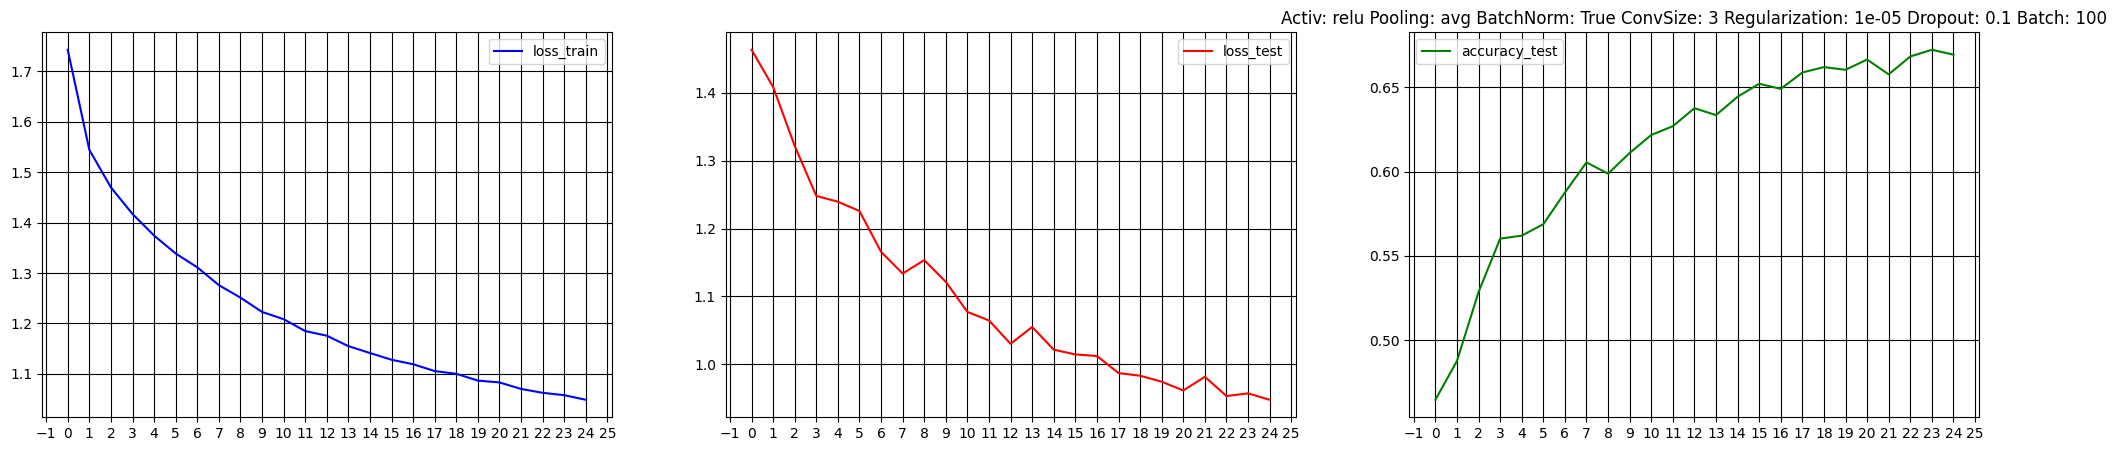

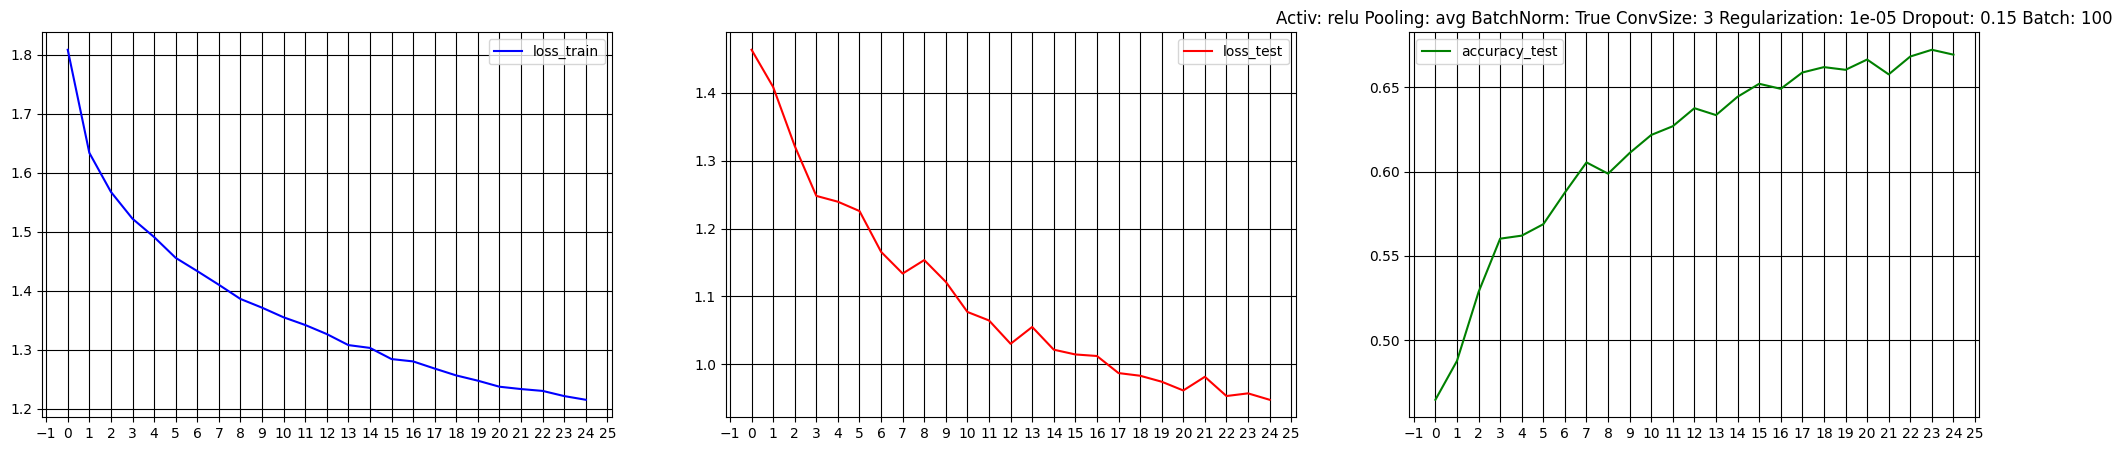

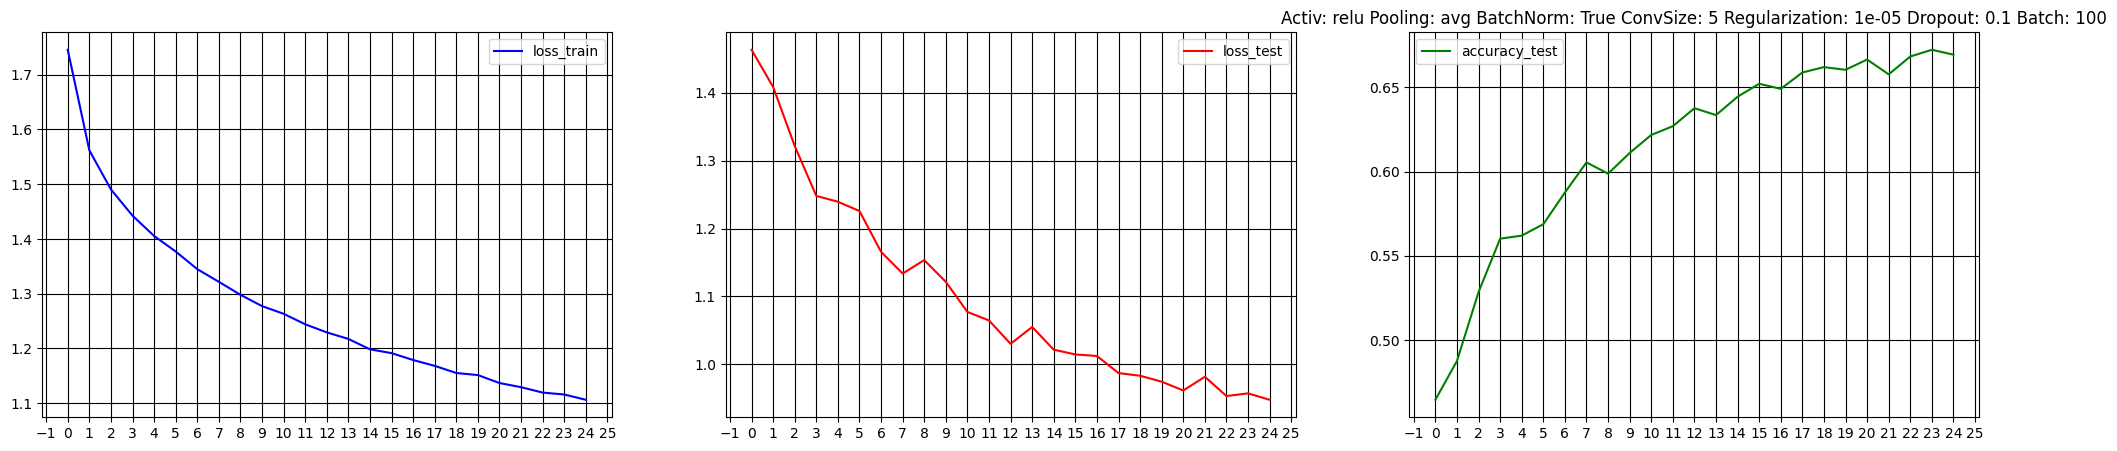

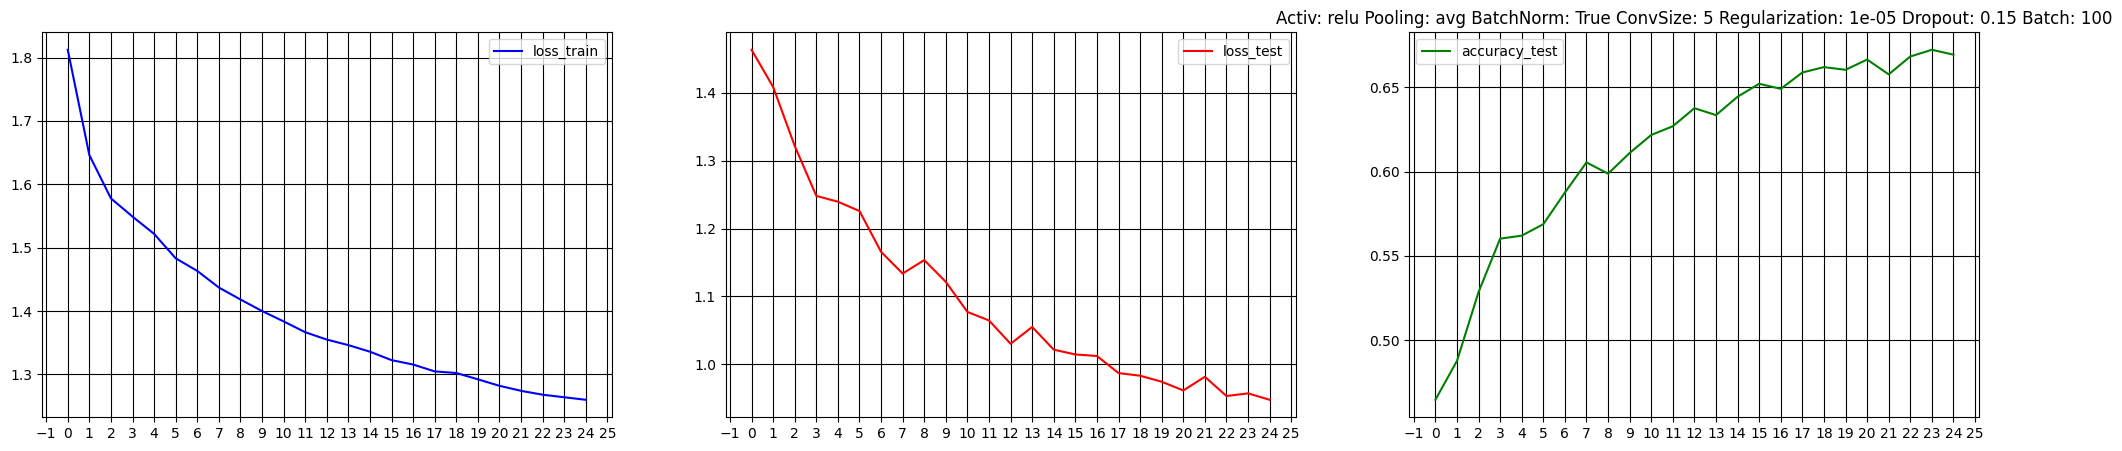

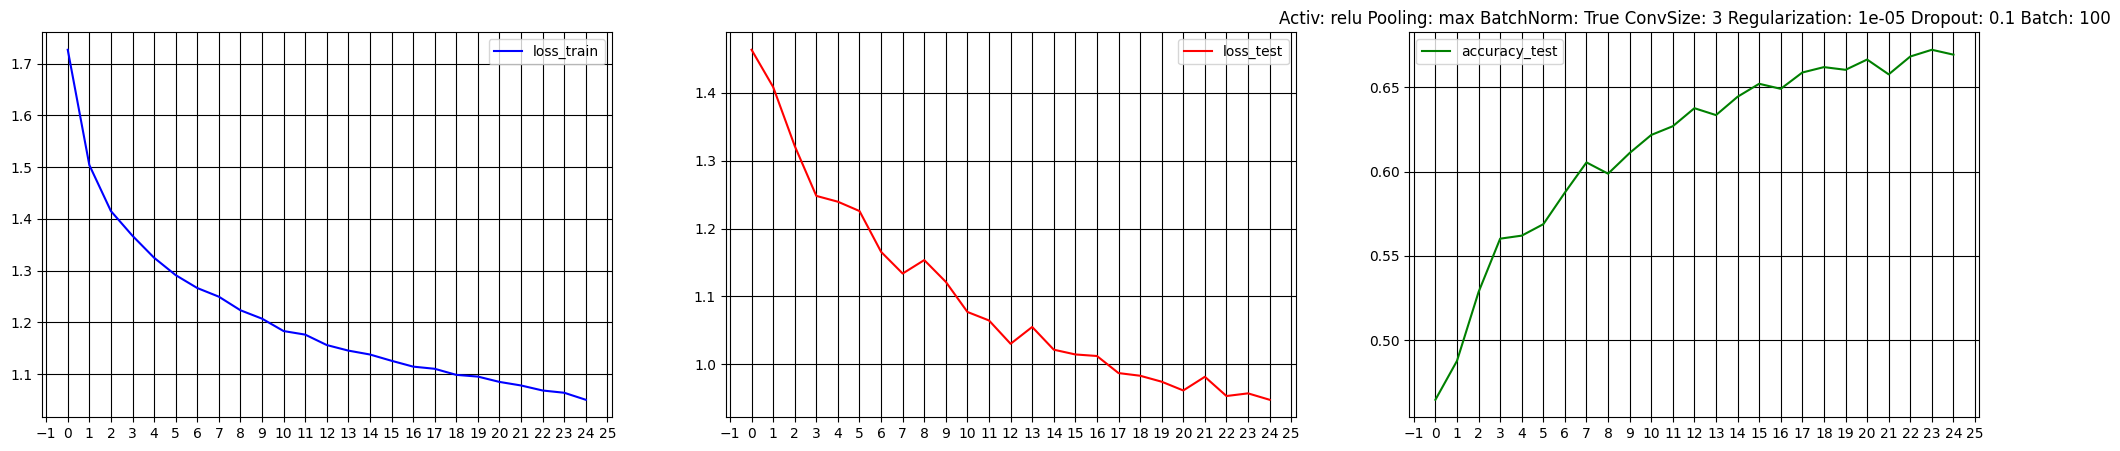

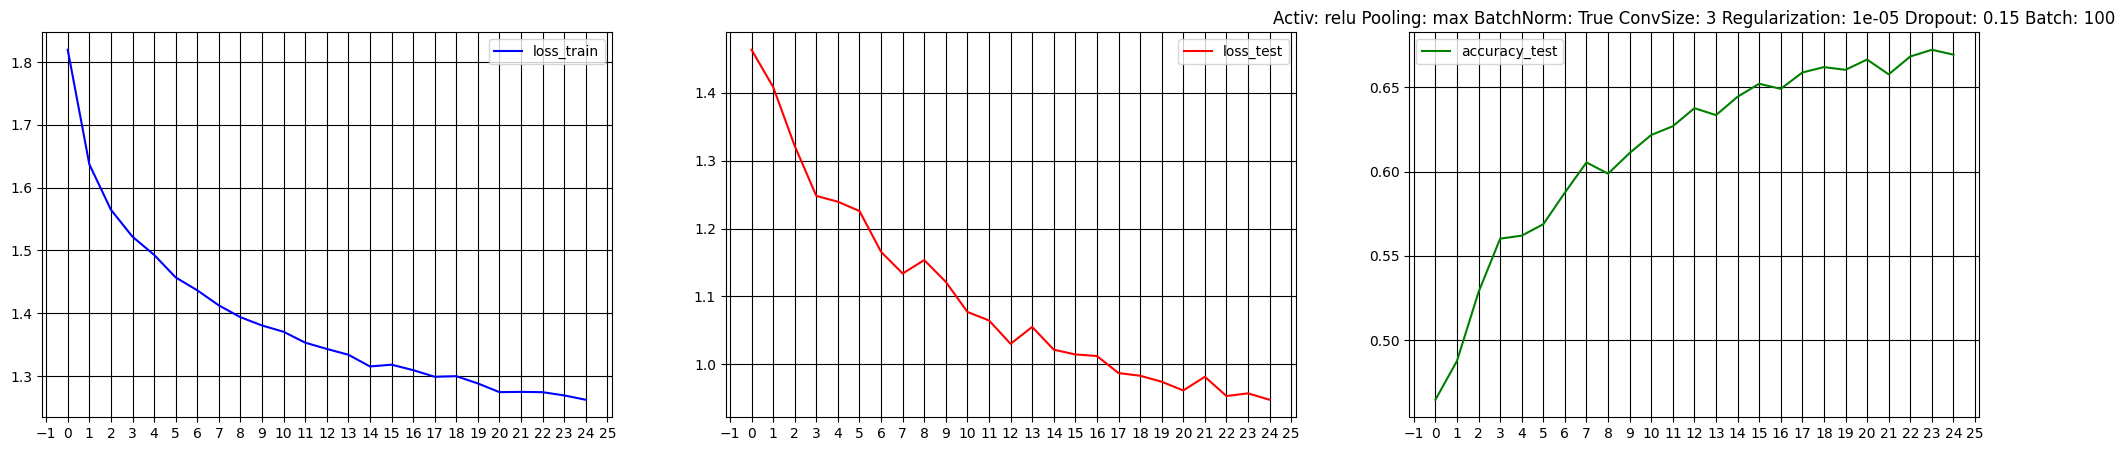

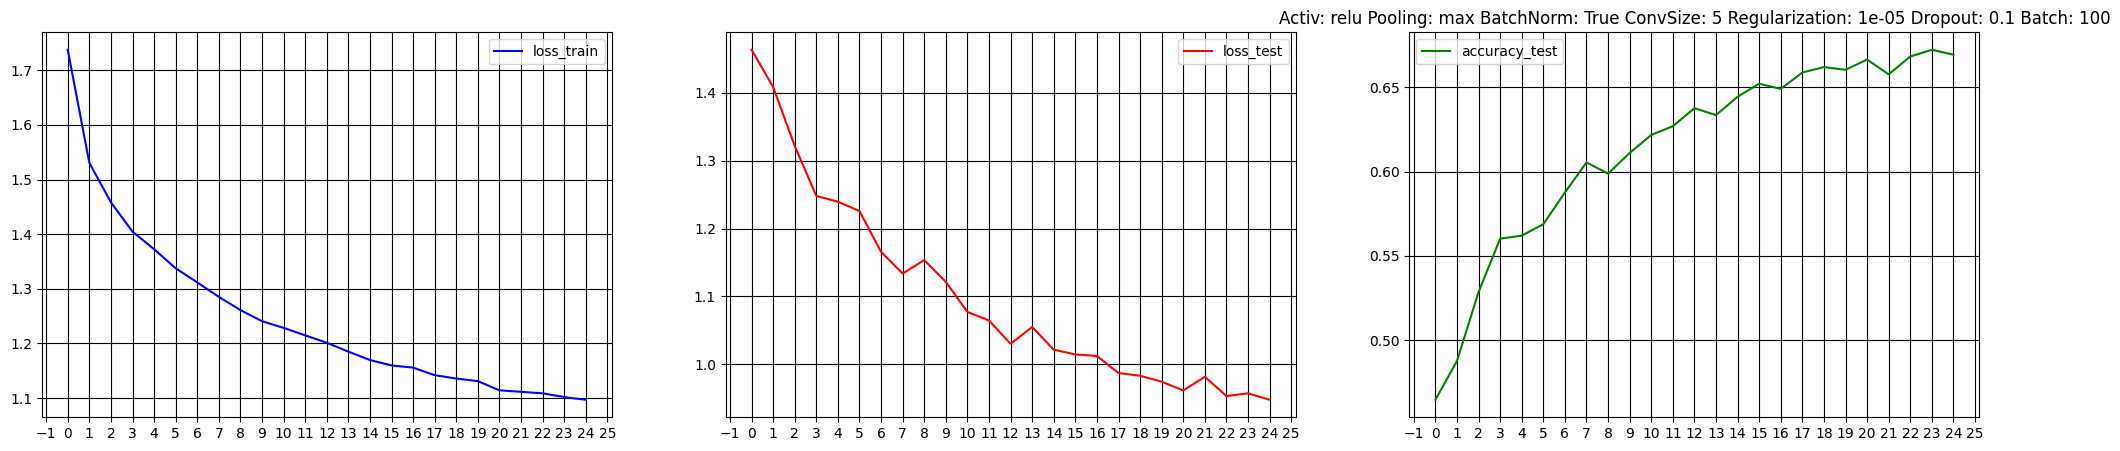

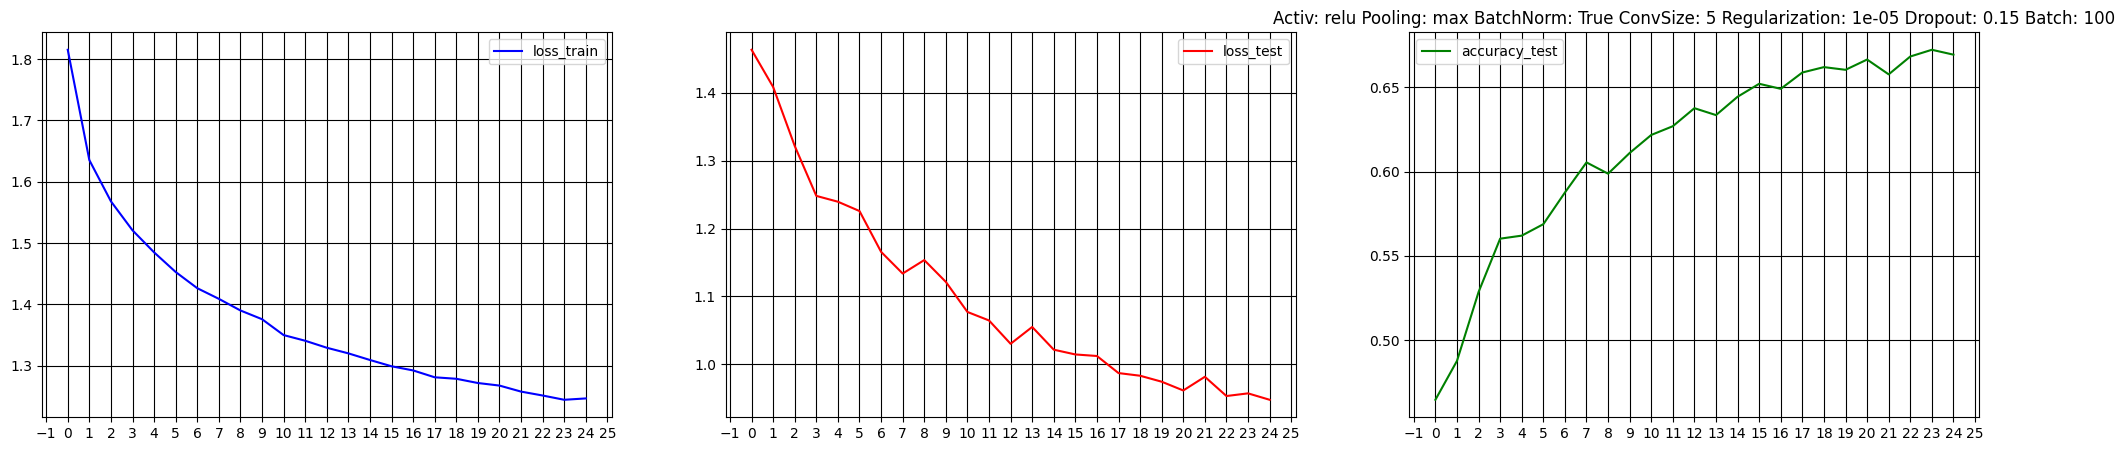

In [ ]:
for i in df.index:
  plt.figure(figsize=(25, 5))


  plt.title(df.loc[[i],['name']].values[0][0])

  ax = plt.subplot(1,3,1)
  plt.plot(df.loc[[i],['loss_train']].values[0][0],c='blue',label='loss_train')
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(which='major',color = 'k')
  plt.legend()

  ax = plt.subplot(1,3,2)
  plt.plot(df.loc[[0],['loss_test']].values[0][0],c='red',label='loss_test')
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(which='major',color = 'k')
  plt.legend()

  ax = plt.subplot(1,3,3)
  plt.plot(df.loc[[0],['accuracy_test']].values[0][0],c='green',label='accuracy_test')
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(which='major',color = 'k')
  plt.legend()

  plt.title(df.loc[[i],['name']].values[0][0])


In [ ]:
plt.close('all')

Google and Microsoft maded inception block and residual block. This blocks helps a lot in calculating gradients in back propagation! prefer to use really deep networks with residual blocks (see ResNet,GoogLeNet)

In [ ]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A',
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act  = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)

        # Если размер меняется , то мы меняем и входной размер
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], \
                                            (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = torch.nn.Sequential(
                     torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out)
        out = self.act(out)


        out = self.conv2(out)
        if self.use_batch_norm:
          out = self.bn2(out)
        if self.use_drop_out:
          out = self.d_out2(out)
        #поэлементное сложение
        out += self.shortcut(x)
        out = self.act(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.15):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act  = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride,
                                use_batch_norm=self.use_batch_norm,
                               use_drop_out=self.use_drop_out,
                               d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
          out = self.bn1(out)
        if self.use_drop_out:
          out = self.d_out1(out)

        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])

def resnet110_no_bn():
    return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False)

def resnet110_d_out15():
    return ResNet(BasicBlock, [18, 18, 18], use_drop_out=True, d_out_p=0.15)

def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

def resnet20_d_out5():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)

def resnet20_d_out3(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.3)

def resnet20_d_out8():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.8)

def resnet20_d_out15():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.15)

GLOBAL PARAMETERS

In [ ]:
num_blocks = [[3,3,3]]
use_dropouts = [True]
dropouts_prob = [0.15,0.2,0.3]
regularizations = [1.0e-5]
batches = [50]

In [ ]:
# train(resnet20(),
#       X_train,y_train,X_test,y_test,
#       1.0e-5,100,EarlyStopper(2,0.05),use_early_stopper=True,verbose=True)

Epoch is  0 , loss_train: 1.353735 , loss_val: 1.2468377351760864 , accuracy: 0.5558000206947327
Epoch is  1 , loss_train: 0.9377935 , loss_val: 0.9260114431381226 , accuracy: 0.6650000214576721
Epoch is  2 , loss_train: 0.7810056 , loss_val: 0.8892403244972229 , accuracy: 0.6834999918937683
Epoch is  3 , loss_train: 0.65772974 , loss_val: 1.1202324628829956 , accuracy: 0.6431000232696533
Epoch is  4 , loss_train: 0.57225645 , loss_val: 0.995697557926178 , accuracy: 0.6711000204086304
Early stopper stopped training on epoch:  4


([1.353735, 0.9377935, 0.7810056, 0.65772974, 0.57225645],
 [1.2468377351760864,
  0.9260114431381226,
  0.8892403244972229,
  1.1202324628829956,
  0.995697557926178],
 [0.5558000206947327,
  0.6650000214576721,
  0.6834999918937683,
  0.6431000232696533,
  0.6711000204086304])

In [ ]:
df = pd.DataFrame(columns = ['name','loss_train','loss_test','accuracy_test'])
i=1
start_time = time.time()
total_models = len(num_blocks)*len(use_dropouts)*len(dropouts_prob)*len(regularizations)*len(batches)
for num_block in num_blocks:
  for use_dropout in use_dropouts:
    for dropout_prob in dropouts_prob:
      for regularization in regularizations:
        for batch in batches:
          print("Current model: "+str(i)+"/"+str(total_models)+" Size of blocks: "+str(num_block)+
                  " Using dropouts: "+str(use_dropout)+
                  " Dropout probability: "+str(dropout_prob)+
                  " Regularization: "+str(regularization)+
                  " Batch: "+str(batch)+
                  " Elapsed time : "+ str(time.time()-start_time))
          loss_train,loss_test,accuracy_test = train(
              ResNet(BasicBlock,num_block,num_classes=10,use_batch_norm=True,use_drop_out=use_dropout,d_out_p=dropout_prob),
              X_train,y_train,X_test,y_test,regularization,batch,EarlyStopper(2,0.01),use_early_stopper = True,verbose=True)
          i+=1
          df = pd.concat([
              df,
              pd.DataFrame({'name' : str(
                  " ResNet"+str(num_block)+
                  " Using dropouts: "+str(use_dropout)+
                  " Dropout probability: "+str(dropout_prob)+
                  " Regularization: "+str(regularization)+
                  " Batch: "+str(batch)
                  ),
                'loss_train' : [loss_train],
                'loss_test' : [loss_test],
                'accuracy_test' : [accuracy_test]
              })
          ],ignore_index = True)

print("All models [",i,"/",total_models,"] trained, elapsed time : ",time.time()-start_time)

Current model: 0/3 Size of blocks: [3, 3, 3] Using dropouts: True Dropout probability: 0.15 Regularization: 1e-05 Batch: 50 Elapsed time : 0.0005826950073242188
Epoch is  0 , loss_train: 1.7316946 , loss_val: 1.4060522317886353 , accuracy: 0.4796000123023987
Epoch is  1 , loss_train: 1.3884661 , loss_val: 1.0847351551055908 , accuracy: 0.6043000221252441
Epoch is  2 , loss_train: 1.2033513 , loss_val: 0.9888628125190735 , accuracy: 0.6491000056266785
Epoch is  3 , loss_train: 1.0853218 , loss_val: 0.8724948167800903 , accuracy: 0.6922000050544739
Epoch is  4 , loss_train: 0.99711365 , loss_val: 0.795708954334259 , accuracy: 0.7210999727249146
Epoch is  5 , loss_train: 0.9219404 , loss_val: 0.7726173996925354 , accuracy: 0.7268000245094299
Epoch is  6 , loss_train: 0.86269385 , loss_val: 0.6989101767539978 , accuracy: 0.7520999908447266
Epoch is  7 , loss_train: 0.81144404 , loss_val: 0.661758542060852 , accuracy: 0.7696999907493591
Epoch is  8 , loss_train: 0.7710731 , loss_val: 0.6314

In [ ]:
df.head()

In [ ]:
for i in df.index:
  plt.figure(figsize=(25, 5))


  plt.title(df.loc[[i],['name']].values[0][0])

  ax = plt.subplot(1,3,1)
  plt.plot(df.loc[[i],['loss_train']].values[0][0],c='blue',label='loss_train')
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(which='major',color = 'k')
  plt.legend()

  ax = plt.subplot(1,3,2)
  plt.plot(df.loc[[0],['loss_test']].values[0][0],c='red',label='loss_test')
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(which='major',color = 'k')
  plt.legend()

  ax = plt.subplot(1,3,3)
  plt.plot(df.loc[[0],['accuracy_test']].values[0][0],c='green',label='accuracy_test')
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(which='major',color = 'k')
  plt.legend()

  plt.title(df.loc[[i],['name']].values[0][0])

In [ ]:
plt.close('all')

Для лучшего прогноза::

*   дальнейшая модификация архитектуры
*   использование более продвинутых архитектур нейронных сетей
*   применения аугментации к датасету
*   создания ансамбля из несколький сетей
